In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import perceval as pcvl

In [3]:
token_qcloud = '<your token>'

In [4]:
class BosonSampler:

    def __init__(self,
                 token,
                 nphotons: int,
                 nmodes: int):

        self.token = token
        self.nphotons = nphotons
        self.nmodes = nmodes
        self.compiled_circuit = None
        self.circuit = None
        self.input_state = None

        self.theoretical_probability = dict()
        self.experimental_distribution = None
        self.experimental_probability = None

        self.qpu_in_use = None
        self.job_status = None
        self.job_running = None

    def generate_random_circuit(self):
        haar_random = pcvl.Matrix.random_unitary(self.nmodes)
        self.circuit = pcvl.components.Unitary(U=haar_random)

    def generate_random_input(self):
        self.input_state = self.nphotons*[1]+(self.nmodes-self.nphotons)*[0]
        np.random.shuffle(self.input_state)

    def get_outcome(self, output_state):
        state = []
        for m in str(output_state):
            if m.isdigit():
                state.append(int(m))
        outcome = ''
        for i in state:
            if i>0:
                outcome+='1'
            else:
                outcome+='0'

        if outcome.count('1') == self.nphotons:
            return outcome
        else:
            return None

    def ground_truth(self,
                     nsamples=1e12):

        assert self.circuit is not None, 'You must first generate a random circuit'
        assert self.input_state is not None, 'You must first generate a random input'

        local_qpu = pcvl.Processor(backend_name="SLOS", m_circuit=self.circuit)
        local_qpu._n_moi=self.circuit.m
        local_qpu.with_input(pcvl.BasicState(self.input_state))
        local_qpu.mode_post_selection(1)

        sampler = pcvl.algorithm.Sampler(local_qpu)
        job = sampler.sample_count(nsamples)
        sv_out = job['results']

        e_t = {}
        for output_state in sv_out:
            outcome = self.get_outcome(output_state)
            if outcome is not None:
                    if outcome in e_t:
                        e_t[outcome] += sv_out[output_state]
                    else:
                        e_t[outcome] = sv_out[output_state]
        # Normalization
        norm_factor = np.sum([e_t[x] for x in e_t.keys()])
        dict_normed = {}
        for outcome in e_t.keys():
            dict_normed[outcome] = e_t[outcome] / norm_factor

        self.theoretical_probability = dict_normed

    def get_distribution(self, qpu='sim:ascella', nsamples=1000):

        assert self.circuit is not None, 'You must first generate a random circuit'
        assert self.input_state is not None, 'You must first generate a random input'

        # Used compiled results to run the circuit on the HARDWARE
        remote_qpu = pcvl.RemoteProcessor(qpu, token_qcloud)
        remote_qpu.with_input(pcvl.BasicState(self.input_state))

        remote_qpu.set_circuit(self.circuit)
        remote_qpu.mode_post_selection(1)
        sampler = pcvl.algorithm.Sampler(remote_qpu)

        job = sampler.sample_count
        async_job = job.execute_async(nsamples)

        self.qpu_in_use = qpu
        self.job_status = async_job
        self.job_running = job

    def analyse_distribution(self):

        assert self.job_status.is_complete, 'Job is still running, please wait'

        remote_processor = pcvl.RemoteProcessor(self.qpu_in_use, self.token)
        job = remote_processor.resume_job(self.job_running.id)
        sv_out = job.get_results()["results"]

        e_t = {}
        for output_state in sv_out:
            outcome = self.get_outcome(output_state)
            if outcome is not None:
                if outcome in e_t:
                    e_t[outcome] += sv_out[output_state]
                else:
                    e_t[outcome] = sv_out[output_state]
        # Normalizaiton
        norm_factor = np.sum([e_t[x] for x in e_t.keys()])
        e_t_normed = {}
        for outcome in e_t:
            e_t_normed[outcome] = e_t[outcome] / norm_factor

        self.experimental_distribution = e_t
        self.experimental_probability = e_t_normed

In [5]:
# Utils
def plot_distribution(BS):

    fig, ax = plt.subplots()

    x = sorted(BS.theoretical_probability.keys())
    yth = [-BS.theoretical_probability[x] for x in x]
    yexp = [BS.experimental_probability.get(x,0) for x in x]

    bar1 = sns.barplot(ax = ax , x=x, y=yth, alpha=0.4, lw=0.)
    bar2 = sns.barplot(ax = ax , x=x, y=yexp, lw=0.)
    bar1.set_xticks([])
    bar2.set_xticks([])

    w = ax.get_yticks()
    wmax = round(max(w),2)
    ax.set_yticks([-wmax, -wmax/2, 0, wmax/2, wmax])
    ax.set_yticklabels([str(wmax), str(wmax/2), 0, str(wmax/2), str(wmax)])

    ax.set_ylabel( "Probability" , size = 32)
    ax.grid(False)
    ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, labelsize=30)

    plt.show()

def fidelity(BS):

    F = 0
    for basis in BS.theoretical_probability.keys():
        if basis in BS.experimental_probability:
            F+=np.sqrt(BS.theoretical_probability[basis]*BS.experimental_probability[basis])

    # Error propagation
    F_err = 0
    norm_factor = np.sum([k for k in BS.experimental_distribution.values()])
    for basis in BS.theoretical_probability:
            if basis in BS.experimental_probability and BS.experimental_probability[basis]>0:
                Delta_qi =  np.sqrt(BS.experimental_distribution[basis])/norm_factor
                F_err+=np.sqrt((BS.theoretical_probability[basis])/(2*np.sqrt(BS.experimental_probability[basis])))*Delta_qi

    return F, F_err

def distance(BS):

    D = 0
    for basis in BS.theoretical_probability.keys():
        if basis in BS.experimental_probability:
            D+=abs(BS.theoretical_probability[basis]-BS.experimental_probability[basis])/2

    # Error propagation
    D_err = 0
    norm_factor = np.sum([k for k in BS.experimental_distribution.values()])
    for basis in BS.theoretical_probability:
        if basis in BS.experimental_probability:
            Delta_qi =  np.sqrt(BS.experimental_distribution[basis])/norm_factor
            D_err += 1/2*Delta_qi

    return D, D_err

In [12]:
nphotons = 2
nmodes = 12
nsamples = 1e6
platform = 'qpu:ascella'

In [19]:
bs = BosonSampler(token=token_qcloud, nphotons=nphotons, nmodes=nmodes)

bs.generate_random_circuit()
bs.generate_random_input()

In [23]:
# Compute the experimental distribution from the compiled circuit
bs.get_distribution(qpu=platform, nsamples=nsamples)

In [24]:
# Compute the experimental probabilities from the experimental distribution
bs.analyse_distribution()
# Compute theoretical probabilities from the unitary Haar matrix
bs.ground_truth(nsamples=nsamples)

In [25]:
F, errF = fidelity(bs)
D, errD = distance(bs)
print(f'Fidelity = {round(F,5)}±{round(errF,5)}')
print(f'Distance = {round(D,5)}±{round(errD,5)}')

Fidelity = 0.99327±0.01164
Distance = 0.08746±0.02302


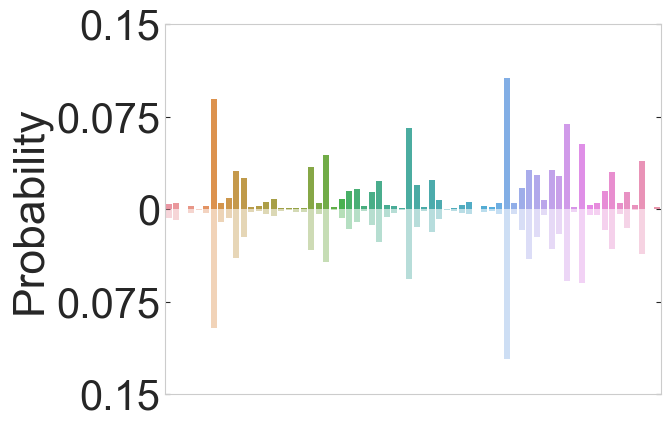

In [17]:
plot_distribution(bs)